# 2019320016 차주한

### Preprocess data using leammatizer

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

def tokenizer(text):
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return tokens


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hanchaa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hanchaa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hanchaa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Load dataset and split into train & validation

In [4]:
import torch
from torchtext.legacy import data
from torchtext.legacy.data import TabularDataset

mail_field = data.Field(sequential=True, use_vocab=True, tokenize=tokenizer, lower=True, batch_first=True, fix_length=300)
label_field = data.Field(sequential=False, use_vocab=False, batch_first=False, is_target=True)
id_field = data.Field(sequential=False, use_vocab=False, batch_first=False, is_target=True)

loaded_data = TabularDataset(path="./data/train.csv",
                                 format="csv",
                                 fields=[("id" , id_field), ("label", label_field), ("mail", mail_field)],
                                 skip_header=True)

train_data, val_data = loaded_data.split(split_ratio=0.9, stratified=True, strata_field="label")

print("train data: ", len(train_data))
print(train_data.fields)
print("validation data: ", len(val_data))
print(val_data.fields)

train data:  3258
{'id': <torchtext.legacy.data.field.Field object at 0x000001F714D8FDF0>, 'label': <torchtext.legacy.data.field.Field object at 0x000001F714D8FD30>, 'mail': <torchtext.legacy.data.field.Field object at 0x000001F714D8FCD0>}
validation data:  362
{'id': <torchtext.legacy.data.field.Field object at 0x000001F714D8FDF0>, 'label': <torchtext.legacy.data.field.Field object at 0x000001F714D8FD30>, 'mail': <torchtext.legacy.data.field.Field object at 0x000001F714D8FCD0>}


### Build vocabulary dictionary

In [62]:
mail_field.build_vocab(train_data, min_freq=3)
print("size of vocab: ", len(mail_field.vocab))
print(mail_field.vocab.stoi)

size of vocab:  10297
defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x000001F70FAEC280>>, {'<unk>': 0, '<pad>': 1, '-': 2, '.': 3, '/': 4, ',': 5, ':': 6, 'ect': 7, '@': 8, "'": 9, 'subject': 10, 'hou': 11, '?': 12, 'enron': 13, ')': 14, '=': 15, '(': 16, ';': 17, '>': 18, '2000': 19, 'com': 20, '!': 21, 'deal': 22, '_': 23, 'please': 24, '3': 25, '``': 26, 'gas': 27, '$': 28, '1': 29, 'meter': 30, '#': 31, '2': 32, '00': 33, 'cc': 34, 'pm': 35, 'hpl': 36, '000': 37, '10': 38, 'e': 39, '2001': 40, 'corp': 41, 'thanks': 42, '01': 43, 'daren': 44, 'need': 45, '0': 46, '|': 47, '*': 48, 'volume': 49, '&': 50, 'know': 51, '4': 52, 'price': 53, 'day': 54, '5': 55, '%': 56, 'new': 57, '11': 58, 'http': 59, 'j': 60, 'mmbtu': 61, 'get': 62, 'forwarded': 63, 'l': 64, 'u': 65, '12': 66, '03': 67, 'company': 68, 'may': 69, 'see': 70, 'information': 71, 'change': 72, 'farmer': 73, 'attached': 74, 'let': 75, 'xl': 76, 'time': 77, 'contract': 78, '7': 

### Make data loader

In [63]:
from torchtext.legacy.data import Iterator

batch_size = 32
train_loader = Iterator(dataset=train_data, batch_size=batch_size, device="cuda")
val_loader = Iterator(dataset=val_data, batch_size=len(val_data), device="cuda", shuffle=False)

### Make recurrent net model

In [10]:
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self, n_layers, hidden_size, embedding_dim, dropout):
        super(MyModel, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=len(mail_field.vocab), embedding_dim=embedding_dim, padding_idx=1)
        self.rnn = nn.GRU(num_layers=n_layers,input_size=embedding_dim ,hidden_size=hidden_size, batch_first=True)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        embedded = self.embedding(x)
        h, _ = self.rnn(embedded)
        h_t = h[:, -1, :]
        activation = self.relu(h_t)
        dropped = self.dropout(activation)
        logit = self.linear(dropped)
        return logit.squeeze()

### Train & evaluate function

In [11]:
from sklearn.metrics import f1_score

def train(model, loss_fn, optimizer, loader):
    model.train()
    for batch in loader:
        x, y = batch.mail, batch.label
        optimizer.zero_grad()

        logit = model(x)
        loss = loss_fn(logit, y.float())
        loss.backward()

        optimizer.step()

def evaluate(model, loss_fn, loader):
    model.eval()
    total_loss, corrects = 0, 0

    y_predict = torch.tensor([]).to("cuda")
    y_true = torch.tensor(()).to("cuda")

    for batch in loader:
        x,y = batch.mail, batch.label

        logit = model(x)
        loss = loss_fn(logit, y.float())
        total_loss += loss.item()

        predicted = (logit > 0) * 1.0
        corrects += (predicted == y).sum()

        y_predict = torch.cat((y_predict, predicted), 0)
        y_true = torch.cat((y_true, y), 0)

    score = f1_score(y_true.cpu(), y_predict.cpu())

    size = len(loader.dataset)
    avg_accuracy = corrects / size
    avg_loss = total_loss / size

    return avg_loss, avg_accuracy, score

In [64]:
import copy

best_val_acc = 0
best_model = None
best_model_history = None

### Train model

In [66]:
train_history = []
val_history = []

model = MyModel(n_layers=1, hidden_size=128, embedding_dim=32, dropout=0.6).to("cuda")

lr = 8e-3
optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)

loss_fn = torch.nn.BCEWithLogitsLoss(reduction="sum").to("cuda")

for e in range(30):
    train(model, loss_fn, optimizer, train_loader)
    train_loss, train_accuracy, train_f1 = evaluate(model, loss_fn, train_loader)
    val_loss, val_accuracy, val_f1 = evaluate(model, loss_fn, val_loader)

    train_history.append(train_accuracy.cpu().item())
    val_history.append(val_accuracy.cpu().item())

    print("[Epoch: %2d] train loss: %5.4f | train accuracy: %5.4f | train f1: %5.2f | val loss: %5.4f | val accuracy: %5.4f | val f1: %5.2f" % (e + 1, train_loss, train_accuracy, train_f1, val_loss, val_accuracy, val_f1))

    if  val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        best_model = copy.deepcopy(model)
        best_model_history = (train_history, val_history)

print("Best model accuracy: ", best_val_acc)

[Epoch:  1] train loss: 0.5529 | train accuracy: 0.7225 | train f1:  0.08 | val loss: 0.5815 | val accuracy: 0.7293 | val f1:  0.16
[Epoch:  2] train loss: 0.5506 | train accuracy: 0.7452 | train f1:  0.26 | val loss: 0.5688 | val accuracy: 0.7320 | val f1:  0.21
[Epoch:  3] train loss: 0.5169 | train accuracy: 0.7575 | train f1:  0.30 | val loss: 0.5299 | val accuracy: 0.7762 | val f1:  0.43
[Epoch:  4] train loss: 0.4459 | train accuracy: 0.8076 | train f1:  0.55 | val loss: 0.4824 | val accuracy: 0.7873 | val f1:  0.55
[Epoch:  5] train loss: 0.4718 | train accuracy: 0.7864 | train f1:  0.46 | val loss: 0.4631 | val accuracy: 0.8204 | val f1:  0.60
[Epoch:  6] train loss: 0.3579 | train accuracy: 0.8490 | train f1:  0.68 | val loss: 0.3801 | val accuracy: 0.8398 | val f1:  0.70
[Epoch:  7] train loss: 0.2994 | train accuracy: 0.8969 | train f1:  0.82 | val loss: 0.3911 | val accuracy: 0.8370 | val f1:  0.75
[Epoch:  8] train loss: 0.2208 | train accuracy: 0.9067 | train f1:  0.81 | 

### Visualize GRU train history

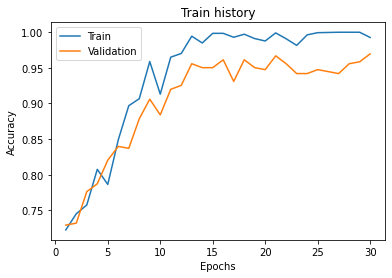

In [67]:
from matplotlib import pyplot as plt
epochs = list(range(1, 31))

plt.plot(epochs, best_model_history[0])
plt.plot(epochs, best_model_history[1])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train history")
plt.legend(["Train", "Validation"])
plt.show()

### Prepare datas for naive bayse

In [68]:
X_train = []
y_train = []
X_val = []
y_val = []

for i in train_data:
    X_train.append(" ".join(i.mail))
    y_train.append(i.label)

for i in val_data:
    X_val.append(" ".join(i.mail))
    y_val.append(i.label)

print(vars(train_data[0]))
print("label: ", y_train[0], ", mail: ", X_train[0])

print(vars(val_data[0]))
print("label: ", y_val[0], ", mail: ", X_val[0])

{'id': '3225', 'label': '0', 'mail': ['subject', ':', ':', 'ua', '4', 'status', 'meter', '?', 'howard', 'b', 'camp', '01', '/', '28', '/', '2000', '07', ':', '17', ':', 'susan', 'trevino', '/', 'hou', '/', 'ect', '@', 'ect', 'cc', ':', 'subject', ':', 'ua', '4', 'susan', ',', 'note', 'sent', 'daren', '.', 'never', 'scheduled', 'park', 'ride', 'idea', 'set', '.', 'hc', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', 'forwarded', 'howard', 'b', 'camp', '/', 'hou', '/', 'ect', '01', '/', '28', '/', '2000', '07', ':', '16', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', 'howard', 'b', 'camp', '01', '/', '27', '/', '2000', '10', ':', '17', ':', 'daren', 'j', 'farmer', '/', 'hou', '/', 'ect', '@', 'ect', 'cc', ':', 'charlotte', 'hawkins', '/', 'hou', '/', 'ect', '@', 'ect', ',', 'anita', 'luong', '/', 'hou', '/', 'ect', '@', 'ect', ',', 'howard

### Make word of bag and transform to feature vector

In [69]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(tokenizer=str.split, min_df=3)
X_train_vectorized = vectorizer.fit_transform(X_train)
print("subject dtm shape: " + str(X_train_vectorized.shape))

subject dtm shape: (3258, 8928)


### Train Naive Bayse

In [38]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

NB_model = MultinomialNB(alpha=0.001)
NB_model.fit(X_train_vectorized, y_train)

predicted = NB_model.predict(X_train_vectorized)
print("Train accuracy: ", accuracy_score(y_train, predicted))

Train accuracy:  0.9895641497851443


### Test validation set on Naive Bayse

In [39]:
X_val_vectorized = vectorizer.transform(X_val)
predicted = NB_model.predict(X_val_vectorized)

print("Validation accuracy: ", accuracy_score(y_val, predicted))

Validation accuracy:  0.9751381215469613


### Train SVM

In [45]:
from sklearn.svm import SVC

SVM_model = SVC(kernel="linear", C=0.01, probability=True)
SVM_model.fit(X_train_vectorized, y_train)

predicted = SVM_model.predict(X_train_vectorized)
print("Train accuracy: ", accuracy_score(y_train, predicted))

Train accuracy:  0.9880294659300184


### Test validation set on SVM

In [46]:
predicted = SVM_model.predict(X_val_vectorized)

print("Validation accuracy: ", accuracy_score(y_val, predicted))

Validation accuracy:  0.9723756906077348


### Validation on ensemble of GRU and Naive Bayse

In [61]:
best_model.eval()

for batch in val_loader:
    x = batch.mail
    id = batch.id

    logit = best_model(x)
    gru_proba = nn.Sigmoid()(logit).detach().cpu().numpy()

NB_proba = NB_model.predict_proba(X_val_vectorized)[:, 1]
SVM_proba = SVM_model.predict_proba(X_val_vectorized)[:, 1]

p1 = 0.5
p2 = 0.5

ensembled_proba = p1 * gru_proba + p2 * NB_proba
ensembled_predicted = ['0' if x == 0 else '1' for x in (ensembled_proba > 0.5) * 1]

print(y_val)
print(ensembled_predicted)

print(accuracy_score(y_val, ensembled_predicted))

['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',

### Predict on test data

In [59]:
test_data = TabularDataset(path="./data/test.csv",
                                 format="csv",
                                 fields=[("id" , id_field), ("mail", mail_field)],
                                 skip_header=True)

test_loader = Iterator(dataset=test_data, batch_size=len(test_data), device="cuda", shuffle=False)

best_model.eval()

for batch in test_loader:
    x = batch.mail
    id = batch.id

    print(id)

    logit = best_model(x)
    gru_proba = nn.Sigmoid()(logit).detach().cpu().numpy()

X_test = []

for i in test_data:
    X_test.append(" ".join(i.mail))

X_test_vectorized = vectorizer.transform(X_test)
NB_proba = NB_model.predict_proba(X_test_vectorized)[:, 1]
SVM_proba = SVM_model.predict_proba(X_test_vectorized)[:, 1]

ensembled_proba = p1 * gru_proba + p2 * NB_proba
ensembled_predicted = (ensembled_proba > 0.5) * 1

print(ensembled_predicted)

tensor([   0,    1,    2,  ..., 1548, 1549, 1550], device='cuda:0')


C:\Users\hanchaa\anaconda3\envs\COSE362\lib\site-packages\torch\nn\modules\rnn.py:849: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ..\aten\src\ATen\native\cudnn\RNN.cpp:925.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


[0 0 0 ... 1 0 0]


In [60]:
import csv

f = open("temp.csv", "w", newline="")
wr = csv.writer(f)
wr.writerow(["id", "label"])

id = 0
for i in ensembled_predicted:
    wr.writerow([id, i])
    id += 1

f.close()